# Fashion MNIST with CNN

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

In [2]:
import numpy as np
import matplotlib.pyplot as plt

### Load the training dataset

In [7]:
train_dataset = FashionMNIST(
    root=".",
    train=True,
    transform=ToTensor(),
    download=True
)

100%|██████████| 26.4M/26.4M [02:22<00:00, 185kB/s] 


Extracting .\FashionMNIST\raw\train-images-idx3-ubyte.gz to .\FashionMNIST\raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 329kB/s]


Extracting .\FashionMNIST\raw\train-labels-idx1-ubyte.gz to .\FashionMNIST\raw



100%|██████████| 4.42M/4.42M [00:15<00:00, 282kB/s]


Extracting .\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to .\FashionMNIST\raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 1.34MB/s]

Extracting .\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to .\FashionMNIST\raw



### Load the test dataset

In [8]:
test_dataset = FashionMNIST(
    root=".",
    train=False,
    transform=ToTensor(),
    download=False
)

### Examine the data

In [9]:
train_dataset.data.shape, train_dataset.targets.shape, test_dataset.data.shape, test_dataset.targets.shape

(torch.Size([60000, 28, 28]),
 torch.Size([60000]),
 torch.Size([10000, 28, 28]),
 torch.Size([10000]))

In [10]:
torch.min(train_dataset.data), torch.max(train_dataset.data)

(tensor(0, dtype=torch.uint8), tensor(255, dtype=torch.uint8))

In [ ]:
# How many classes
torch.min(train_dataset.targets), torch.max(train_dataset.targets)

(tensor(0), tensor(9))

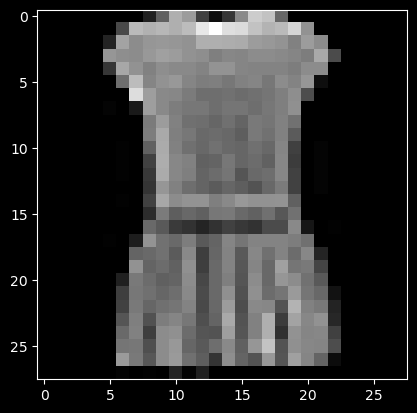

In [12]:
# Sample image
plt.imshow(train_dataset.data[3], cmap="grey")
plt.show()

### Data Loader for train set and test set

In [78]:
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=128)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=128)

### Configure the device

In [23]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

### Build the model (CNN architecture)

In [49]:
class CNN(nn.Module):
    def __init__(self, num_outs, num_hiddens1, drop_out):
        super(CNN, self).__init__()
        # Convolution layer (Stride convolution instead of using pool layers)
        self.conv_layer = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2),
            nn.ReLU(),
        )
        
        # The output shape of the conv layer
        flatten_size = 2 * 2 * 128  # H_out x W_out x # of channels
        
        # ANN layer
        self.dense_layer = nn.Sequential(
            nn.Dropout(drop_out),
            nn.Linear(flatten_size, num_hiddens1),
            nn.ReLU(),
            nn.Dropout(drop_out),
            nn.Linear(num_hiddens1, num_outs),
        )
    
    def forward(self, X):
        y_hat = self.conv_layer(X)
        # Reshape to N by input_shape where N is the number of examples
        y_hat = y_hat.view(y_hat.size(0), -1)
        y_hat = self.dense_layer(y_hat)
        return y_hat

In [50]:
def configure(model, device, lr, optim_method="Adam"):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    if optim_method == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    else:
        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    return criterion, optimizer

In [51]:
def batch_gd(model, criterion, optimizer, device, num_epochs, train_loader, test_loader, record_loss=False):
    # Loss over time for train set and test set
    train_losses = np.zeros(num_epochs)
    test_losses = np.zeros(num_epochs)
    
    # Train the model using batch gradient descend
    for epoch in range(num_epochs):
        # Train mode
        model.train()
        loss_epoch = []
        # Train by batch
        for X_train, y_train in train_loader:
            # Move the data to the device
            X_train, y_train = X_train.to(device), y_train.to(device)
            
            # Zero out the gradient
            optimizer.zero_grad()
            
            # Compute the loss
            y_hat_train = model(X_train)
            loss = criterion(y_hat_train, y_train)
            
            # Record the loss
            loss_epoch.append(loss.item())
            
            # Update the params
            loss.backward()
            optimizer.step()
        
        train_losses[epoch] = np.mean(loss_epoch)
        
        # Compute the test loss, eval mode
        test_loss_epoch = []
        model.eval()
        for X_test, y_test in test_loader:
            X_test, y_test = X_test.to(device), y_test.to(device)
            y_hat_test = model(X_test)
            test_loss = criterion(y_hat_test, y_test)
            test_loss_epoch.append(test_loss.item())
        
        # Record average loss
        test_losses[epoch] = np.mean(test_loss_epoch)
        
        if record_loss:
            print(f"Epoch {epoch}/{num_epochs}: train_loss={loss.item()}; test_loss={test_loss.item()}")
    
    return train_losses, test_losses

### Train the model

In [52]:
# Output shape
num_outs = 10

# Hyperparameters
lr = 0.001
num_hidden1 = 512
# num_hidden2 = 512
drop_out_p = 0.2
optim_method = "Adam"
num_epochs = 15

In [79]:
# Create the model and configure the loss and optimizer
model = CNN(num_outs, num_hidden1, drop_out_p)
criterion, optimizer = configure(model, device, lr, optim_method)

In [54]:
from time import perf_counter

In [80]:
# Train the model
start = perf_counter()
loss_history, test_history = batch_gd(model, criterion, optimizer, device, num_epochs,
                                        train_loader, test_loader)
end = perf_counter()
f"{end - start:.2f}s needed!"

'202.30s needed!'

### Plot out the loss over time

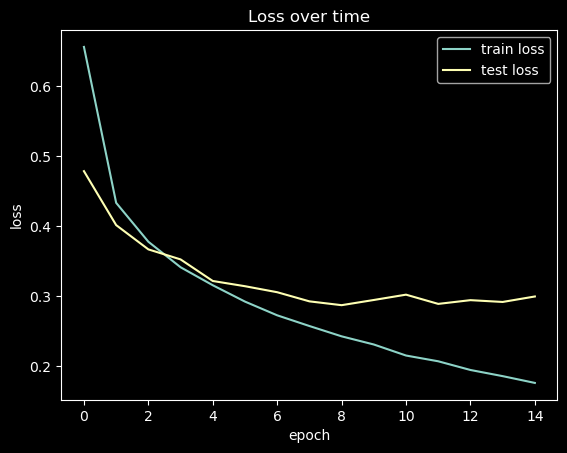

In [81]:
plt.title("Loss over time")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot(loss_history, label="train loss")
plt.plot(test_history, label="test loss")
plt.legend()
plt.show()

### Model accuracy

In [82]:
model.eval()

n_correct, n_total = 0, 0
for inputs, targets in train_loader:
    inputs = inputs.to(device)
    outputs = model(inputs)
    
    _, preds = torch.max(outputs, 1)
    
    n_correct += torch.sum(preds == targets).item()
    n_total += targets.shape[0]
print(f"Train accuracy: {n_correct/n_total:.4f}")

Train accuracy: 0.9519


In [83]:
n_correct, n_total = 0, 0
for inputs, targets in test_loader:
    inputs = inputs.to(device)
    outputs = model(inputs)
    
    _, preds = torch.max(outputs, 1)
    
    n_correct += torch.sum(preds == targets)
    n_total += targets.shape[0]
print(f"Test accuracy: {n_correct/n_total:.4f}")

Test accuracy: 0.9023


### Plot confusion matrix

In [57]:
import sys
import os
sys.path.append(os.path.abspath('../utils'))

from confusion_matrix_plot import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

In [88]:
x_test = test_dataset.data.numpy()
y_test = test_dataset.targets.numpy()
p_test = np.array([])
for inputs, targets in test_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = model(inputs)
    
    _, predictions = torch.max(outputs, 1)
    
    p_test = np.concatenate((p_test, predictions.cpu().numpy()))
np.sum(y_test == p_test)

9023

In [104]:
# Convert number to real labels
classes = train_dataset.classes

Confusion matrix with no normalization
[[887   1  20  15   6   1  65   0   5   0]
 [  4 981   0  10   2   0   1   0   2   0]
 [ 16   0 850  10  71   0  50   0   3   0]
 [ 18  11  14 900  41   0  15   0   1   0]
 [  0   2  32  14 904   0  47   0   1   0]
 [  0   0   0   2   0 960   0  26   1  11]
 [130   1  64  29 126   0 640   0  10   0]
 [  0   0   0   0   0   3   0 967   1  29]
 [  1   2   4   2   5   2   4   6 974   0]
 [  1   1   0   0   0   6   0  32   0 960]]


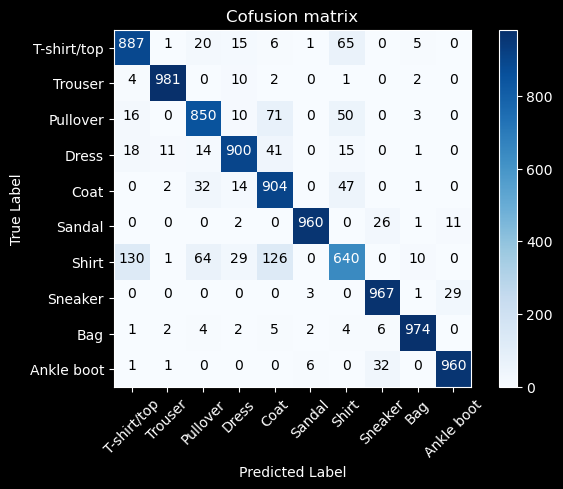

In [106]:
cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, classes)

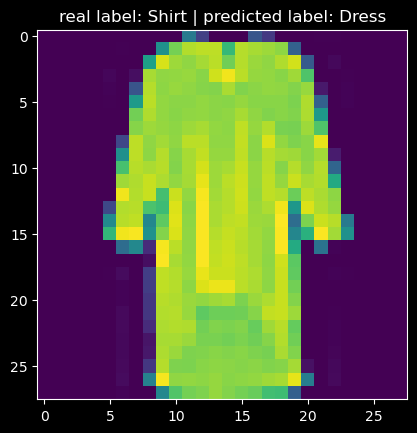

In [103]:
# Plot some misiden. images
p_test = p_test.astype(np.uint8)
misiden_idx = np.where(p_test != y_test)[0]
idx = np.random.choice(misiden_idx)
plt.title(f"real label: {classes[y_test[idx]]} | predicted label: {classes[p_test[idx]]}")
plt.imshow(test_dataset.data[idx])
plt.show()